In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from scipy import stats
import random
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module = "scipy", message = "^internal gelsd")


C:\Users\jerem\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\jerem\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
file = 'wine_quality_red.csv'
wine_data = pd.read_csv(file)
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Data Visualization

I will be using "fixed acidity" as my dependent variable for a regression analysis since the data on "quality" are numeric discrete values. Acidity adds to the sourness or tartness of wine which affects taste, pH, color, stability to oxidation and overall lifespan of the wine.

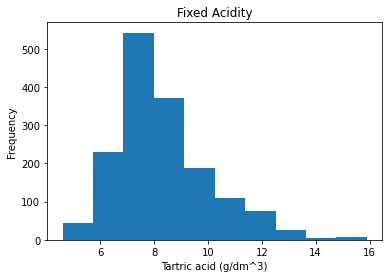

count    1599.000000
mean        8.319637
std         1.741096
min         4.600000
25%         7.100000
50%         7.900000
75%         9.200000
max        15.900000
Name: fixed acidity, dtype: float64

In [3]:
plt.hist(wine_data['fixed acidity'])
plt.title('Fixed Acidity')
plt.xlabel('Tartric acid (g/dm^3)')
plt.ylabel('Frequency')
plt.show()

wine_data['fixed acidity'].describe()


In [4]:
wine_data.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


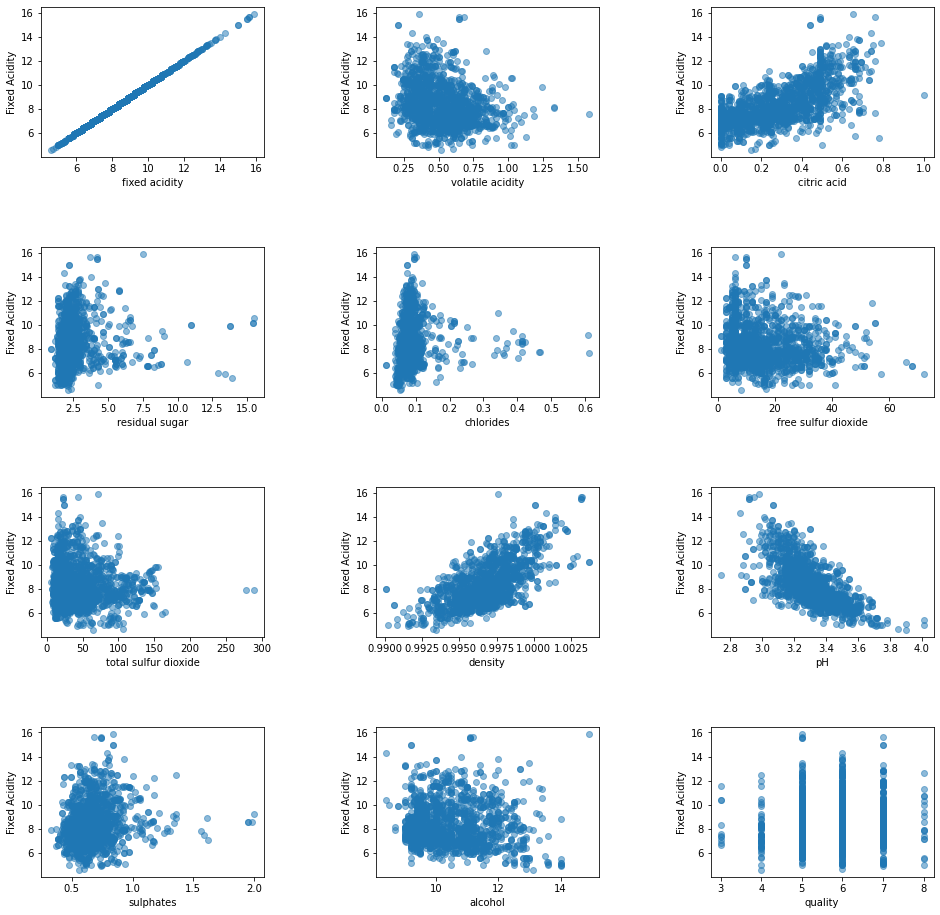

In [5]:
def scatterplots(columns, ncol=None, figsize=(15,8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns)/ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze = False)
    fig.subplots_adjust(wspace=0.5, hspace = 0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x=col, y = 'fixed acidity', data = wine_data, alpha = 0.5)
        ax.set(xlabel = col, ylabel = 'Fixed Acidity')
    nsublots = nrow *ncol
    for empty in range(i+1, nsublots):
        axes.flatten()[empty].set_visible(False)

attributes = [column for column in wine_data.columns]
scatterplots(attributes, ncol=3, figsize = (16, 16))

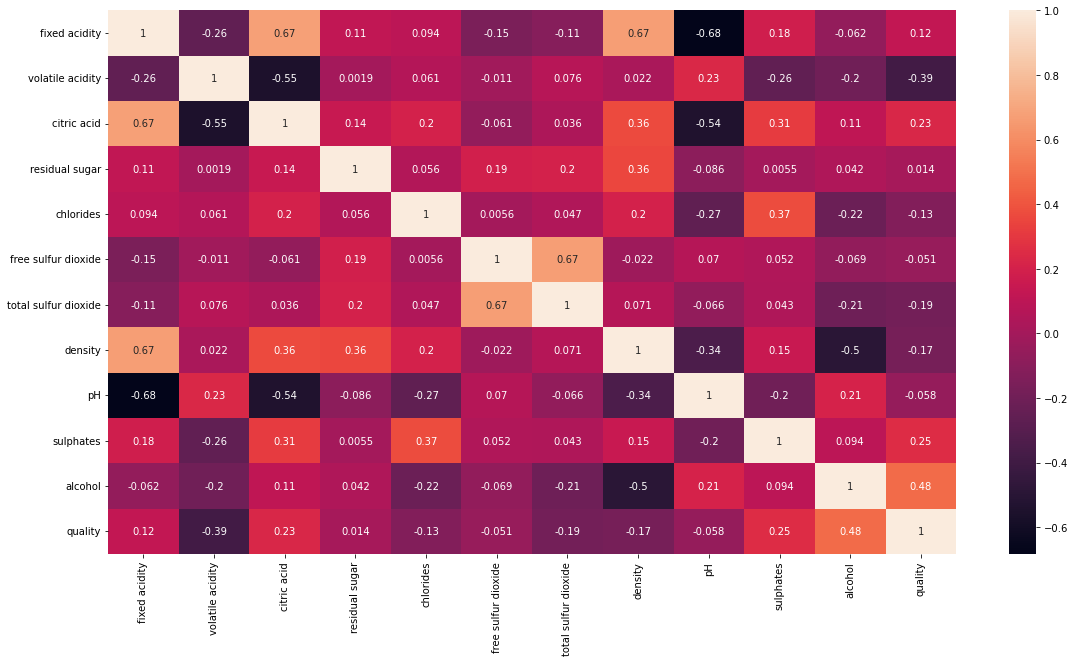

In [6]:
plt.figure(figsize = [19,10,])
sns.heatmap(wine_data.corr(), annot=True)
plt.show()

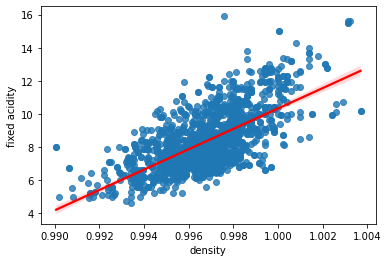

In [7]:
sns.regplot(x='density', y='fixed acidity', data = wine_data, line_kws={'color':'red'})
plt.show()

# Linear Regression Modeling

In [8]:
X = wine_data[['density']]
X = sm.add_constant(X)
y = wine_data[['fixed acidity']]
X_test, X_train, y_test, y_train = train_test_split(X, y , test_size = .25, random_state = 123)

In [9]:
rModel = sm.OLS(y_train, X_train)
rModel_results = rModel.fit()
rModel_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fixed acidity   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     287.6
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           6.21e-49
Time:                        15:47:34   Log-Likelihood:                -670.88
No. Observations:                 400   AIC:                             1346.
Df Residuals:                     398   BIC:                             1354.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -575.8972     34.448    -16.718      0.000    -643.620    -508.174
density      586.1070     34.563     16.958      0.000     518.158     654.056
==============================================================================
Omnibus:                       20.341   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.293
Skew:                           0.565   Prob(JB):                     1.44e-05
Kurtosis:                       2.752   Cond. No.                     1.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'Model predicted values')

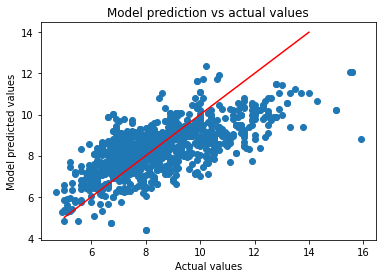

In [10]:
y_pred = rModel_results.predict(X_test)

plt.scatter(y_test, y_pred)
plt.plot([x for x in range(5,15)], [x for x in range(5, 15)], color = 'red')
plt.title("Model prediction vs actual values")
plt.xlabel('Actual values')
plt.ylabel('Model predicted values')

## Multiple Linear Regression Modeling

In [11]:
X = wine_data.drop(['fixed acidity', 'quality'], axis = 1)
X = sm.add_constant(X)
y = wine_data[['fixed acidity']]
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [12]:
rModelm = sm.OLS(y_train, X_train)
rModelm_results = rModelm.fit()
rModelm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fixed acidity   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     280.4
Date:                Thu, 16 Jun 2022   Prob (F-statistic):          5.80e-171
Time:                        15:47:34   Log-Likelihood:                -358.64
No. Observations:                 400   AIC:                             739.3
Df Residuals:                     389   BIC:                             783.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -578.4943     24.775    -23.350      0.000    -627.203    -529.785
volatile acidity         0.4549      0.233      1.956      0.051      -0.002       0.912
citric acid              1.9691      0.265      7.426      0.000       1.448       2.490
residual sugar          -0.2543      0.027     -9.353      0.000      -0.308      -0.201
chlorides               -3.5549      0.901     -3.947      0.000      -5.325      -1.784
free sulfur dioxide      0.0191      0.004      4.340      0.000       0.010       0.028
total sulfur dioxide    -0.0070      0.001     -5.317      0.000      -0.010      -0.004
density                602.4131     24.733     24.356      0.000     553.785     651.041
pH                      -5.5638      0.254    -21.872      0.000      -6.064      -5.064
sulphates               -0.4515      0.202     -2.231      0.026      -0.849      -0.054
alcohol                  0.5055      0.041     12.216      0.000       0.424       0.587
==============================================================================
Omnibus:                        6.307   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                8.966
Skew:                          -0.064   Prob(JB):                       0.0113
Kurtosis:                       3.722   Cond. No.                     6.58e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

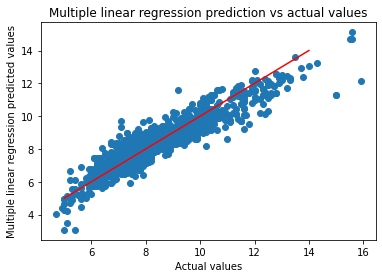

In [13]:
y_pred = rModelm_results.predict(X_test)
plt.scatter(y_test, y_pred)
plt.plot([x for x in range(5,15)], [x for x in range(5,15)], color = 'red')
plt.title('Multiple linear regression prediction vs actual values')
plt.xlabel('Actual values')
plt.ylabel('Multiple linear regression predicted values')
plt.show()

## Wine Quality Analysis

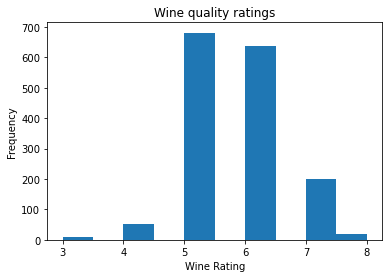

In [14]:
plt.hist(wine_data['quality'])
plt.title('Wine quality ratings')
plt.xlabel('Wine Rating')
plt.ylabel('Frequency')
plt.show()

In [15]:
wine_data['goodquality'] = [1 if x >=7 else 0 for x in wine_data['quality']]

In [20]:
X = wine_data.drop(['quality', 'goodquality'], axis = 1)
y = wine_data['goodquality']

y.value_counts()

0    1382
1     217
Name: goodquality, dtype: int64

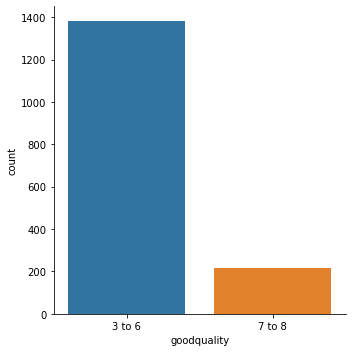

In [35]:
g = sns.catplot(x = 'goodquality', data = wine_data, kind = 'count')
g.set_xticklabels(['3 to 6', '7 to 8'])
plt.show()

In [24]:
from sklearn.preprocessing import StandardScaler
X_features = X
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)